In [1]:
%matplotlib notebook 

import numpy
import matplotlib.pyplot as plot

In [2]:
import matplotlib
matplotlib.rc('text', usetex=True)

In [3]:
numpy.random.seed(1234)

In [4]:
# data set generation
n_dim = 2

n_mean1 = numpy.array([-1., -1.])
n_cov1 = numpy.diag([0.5, .5])
n_mean2 = numpy.array([1., 1.])
n_cov2 = numpy.diag([0.5, .5])

p_mean1 = numpy.array([-1., 1.])
p_cov1 = numpy.diag([.5, .5])
p_mean2 = numpy.array([1., -1.])
p_cov2 = numpy.diag([.5, .5])

# generate postive examples
n_pos = 50
pos_y = numpy.ones(n_pos * 2) 
pos_x = numpy.concatenate([numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov1)[None, :] + p_mean1[None,:],
                           numpy.random.randn(n_pos, n_dim) * numpy.diag(p_cov2)[None, :] + p_mean2[None,:]])
n_pos *= 2
# generate negative examples
n_neg = 50
neg_y = numpy.zeros(n_neg * 2) 
neg_x = numpy.concatenate([numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov1)[None, :] + n_mean1[None,:],
                           numpy.random.randn(n_neg, n_dim) * numpy.diag(n_cov2)[None, :] + n_mean2[None,:]])
n_neg *= 2
# combine them
y = numpy.concatenate([pos_y, neg_y])
x = numpy.concatenate([pos_x, neg_x], axis=0)
# shuffle them
si = numpy.random.permutation(n_pos + n_neg)
y = y[si]
x = x[si]

# grab training examples
n_tra = numpy.round(0.5 * (n_pos + n_neg)).astype(numpy.int)

y_tra = y[:n_tra]
x_tra = x[:n_tra]

y_tes = y[n_tra:]
x_tes = x[n_tra:]

In [5]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [6]:
def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

In [7]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [8]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_) + (1. - y) * numpy.log(1-y_))
    
    if not avg:
        return d
    return numpy.mean(d)

In [9]:
def logreg_rule(y, x, w):
    y_ = logreg(x, w)
    dw = numpy.zeros(w.shape)
    dw[:-1] = numpy.mean((y_tra - y_)[:, None] * x, axis=0)
    dw[-1] = numpy.mean(y_tra - pred_y)
    return dw

In [10]:
n_bases = 25
# select random centroids
cids = numpy.random.permutation(len(x_tra))[:n_bases]
centroids = x_tra[cids]
x_tra_ = rbf(x_tra, centroids, 1.)

w0 = numpy.random.randn(n_bases+1); w0[-1] = 0.
w = numpy.copy(w0)

n_iter = 5000
eta = .1
old_cost = numpy.Inf
for ni in xrange(n_iter):
    pred_y = logreg(x_tra_, w)
    w += eta * logreg_rule(y_tra, x_tra_, w)
    cost = logreg_dist(y_tra, x_tra_, w, avg=True)
    if numpy.mod(ni, 50) == 0:
        print 'RBFN cost {} after iteration {}'.format(cost, ni)
    if cost < 1e-16 or cost / old_cost >= 1.:
        print 'Converged'
        break
    old_cost = cost

RBFN cost 1.7303243925 after iteration 0
RBFN cost 0.732729057435 after iteration 50
RBFN cost 0.523709437316 after iteration 100
RBFN cost 0.419339872153 after iteration 150
RBFN cost 0.359384121453 after iteration 200
RBFN cost 0.321467518977 after iteration 250
RBFN cost 0.295661328911 after iteration 300
RBFN cost 0.277093094803 after iteration 350
RBFN cost 0.263148744714 after iteration 400
RBFN cost 0.252318655506 after iteration 450
RBFN cost 0.243677101596 after iteration 500
RBFN cost 0.236627810273 after iteration 550
RBFN cost 0.230770755507 after iteration 600
RBFN cost 0.225828250368 after iteration 650
RBFN cost 0.221601867755 after iteration 700
RBFN cost 0.2179462499 after iteration 750
RBFN cost 0.214752597181 after iteration 800
RBFN cost 0.211937925761 after iteration 850
RBFN cost 0.209437882944 after iteration 900
RBFN cost 0.207201823601 after iteration 950
RBFN cost 0.205189362363 after iteration 1000
RBFN cost 0.203367912118 after iteration 1050
RBFN cost 0.201

In [11]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [12]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), centroids, 1.)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


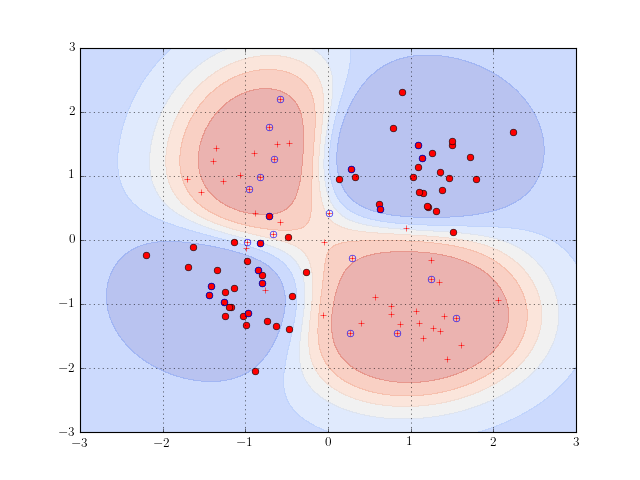

In [13]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(centroids, None, c='b')

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

In [14]:
x_tra_ = rbf(x_tra, centroids, 1.)
x_tes_ = rbf(x_tes, centroids, 1.)

tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra_, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes_, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.07, Test error rate 0.06
